<a href="https://colab.research.google.com/github/ayushsubramanian/Soccer-Image-Segmentation/blob/main/FootballGame_UNET_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import random

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

## Define Function to Load Images and Masks

In [ ]:
def load_images(dataset_dir):
    images, masks = [], [] # Creates empty lists for images and masks

    # Get a list of all files in the images directory
    image_files = os.listdir(os.path.join(dataset_dir, 'images'))

    for file in tqdm(image_files, desc='Loading Images and Masks'):
        # Check if the file is a main image
        if file.endswith('.jpg'): # Filters out all the main images that end with .jpg
            image_path = os.path.join(dataset_dir, 'images', file) # Creates image path
            mask_path = os.path.join(dataset_dir, 'masks', file) # Creates mask path

            # If the mask file exists, the corresponding image and mask are loaded.
            if os.path.exists(mask_path):
                # Loads the image in grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Resizes the image to a size of 256x256 pixels
                image = cv2.resize(image, (256, 256))
                mask = cv2.resize(mask, (256, 256))

                # Appends adjusted images and masks to original list
                images.append(image)
                masks.append(mask)

    return images, masks

## Load Images and Masks from Dataset Path

In [ ]:
# Path to your dataset folder
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/SoccerPlayer_Segmentation_Dataset'

# Load images and masks
images, masks = load_images(dataset_dir)

# Display the number of loaded images and masks
print(f'Loaded {len(images)} images and {len(masks)} masks.')

Loading Images and Masks: 100%|██████████| 512/512 [04:10<00:00,  2.05it/s]

Loaded 512 images and 512 masks.


## Visualize Images and Masks

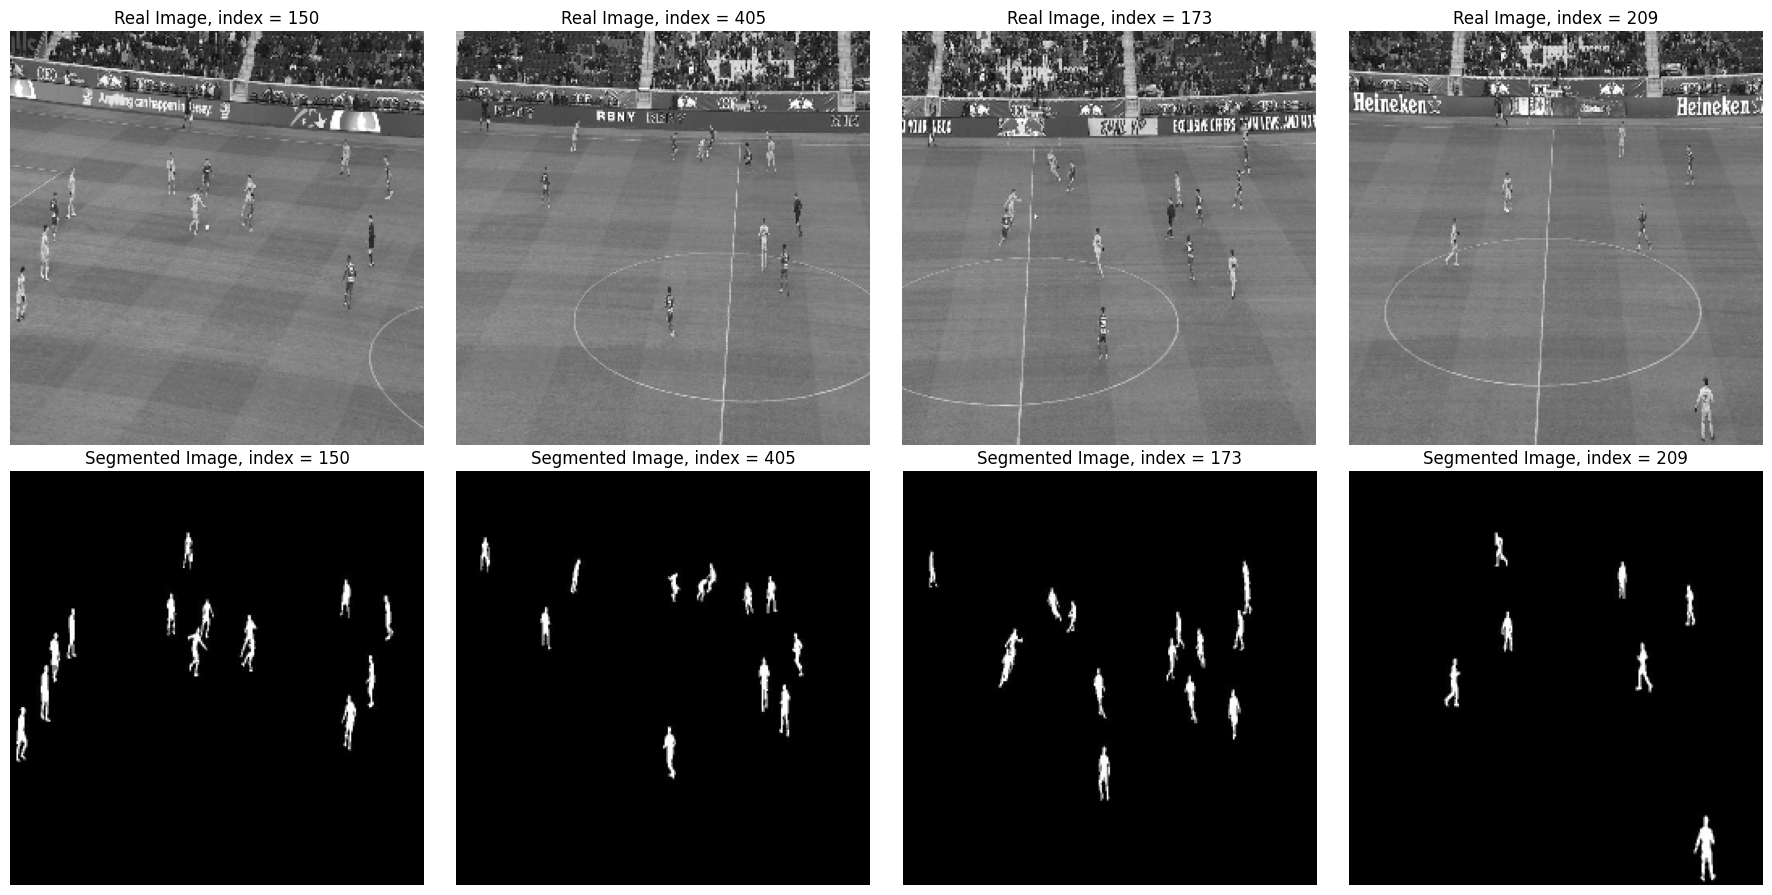

In [ ]:
def plot_image_with_mask(images, masks, num_pairs):
    plt.figure(figsize=(18, 9)) # Creates a new figure for the plot with a size of 18x9 inches
    for i in range(num_pairs):
        idx = random.randint(0, len(images) - 1)  # Generate a random index
        img = images[idx]  # Get the image at the random index
        mask = masks[idx]  # Get the mask at the random index

        plt.subplot(2, num_pairs, i + 1) # Places image plot in the first row
        plt.imshow(img, cmap='gray')  # Display the image using gray colormap
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')

        plt.subplot(2, num_pairs, i + num_pairs + 1) # Places mask plot in the second row
        plt.imshow(mask, cmap='gray')  # Display the mask using gray colormap
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')

    plt.tight_layout() # Adjusts spacing between subplots for better readability
    plt.show() # Displays entire figure with plotted image-mask pairs

plot_image_with_mask(images, masks, 4)


## Converting images to tensors to make it tensorflow compatible
* Converts lists to NumPy arrays because TensorFlow operations typically work with NumPy arrays or TensorFlow tensors, but not Python lists
* Casts the NumPy arrays to `float32` data type, which is commonly used for representing image data in TensorFlow
* Normalizes the pixel values to the range [0, 1] so that the input data is more suitable for neural networks, which typically work better with small input values

In [ ]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list), dtype=tf.float32)) / 255.0
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype=tf.float32)) / 255.0
    return tensor_images, tensor_masks

In [ ]:
images, masks = to_tensor(images, masks) # Assigns images and masks to newly created tensors

In [ ]:
# Calculate the split indices
train_split = round(len(images) * 0.6)
val_split = round(len(images) * 0.2)

# Split the images and masks
images_train, masks_train = images[:train_split], masks[:train_split] # Takes first 60% of dataset for training
images_val, masks_val = images[train_split:train_split + val_split], masks[train_split:train_split + val_split] # Takes next 20% of dataset for validation
images_test, masks_test = images[train_split + val_split:], masks[train_split + val_split:] # Takes last 20% of dataset for testing

# Print the lengths of the sets
print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 307 and 307 respectively
The length of images and masks for validation is 102 and 102 respectively
The length of images and masks for testing is 103 and 103 respectively


## Plot images and masks again for sanity check

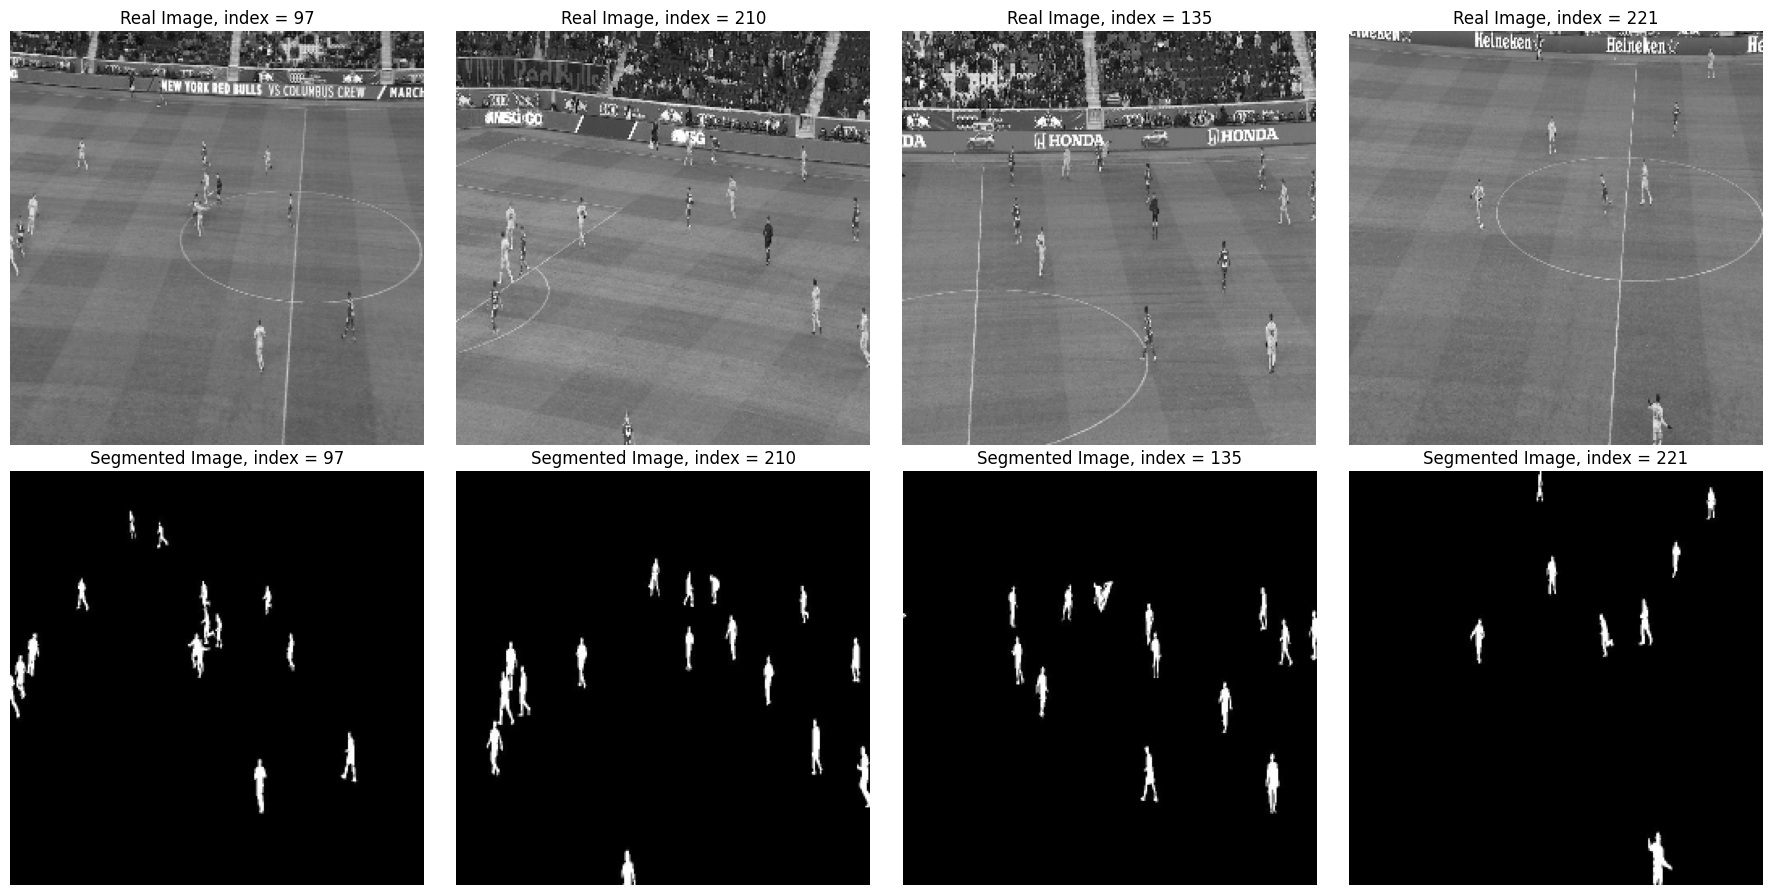

In [ ]:
# Plot training images and masks
plot_image_with_mask(images_train, masks_train, 4)

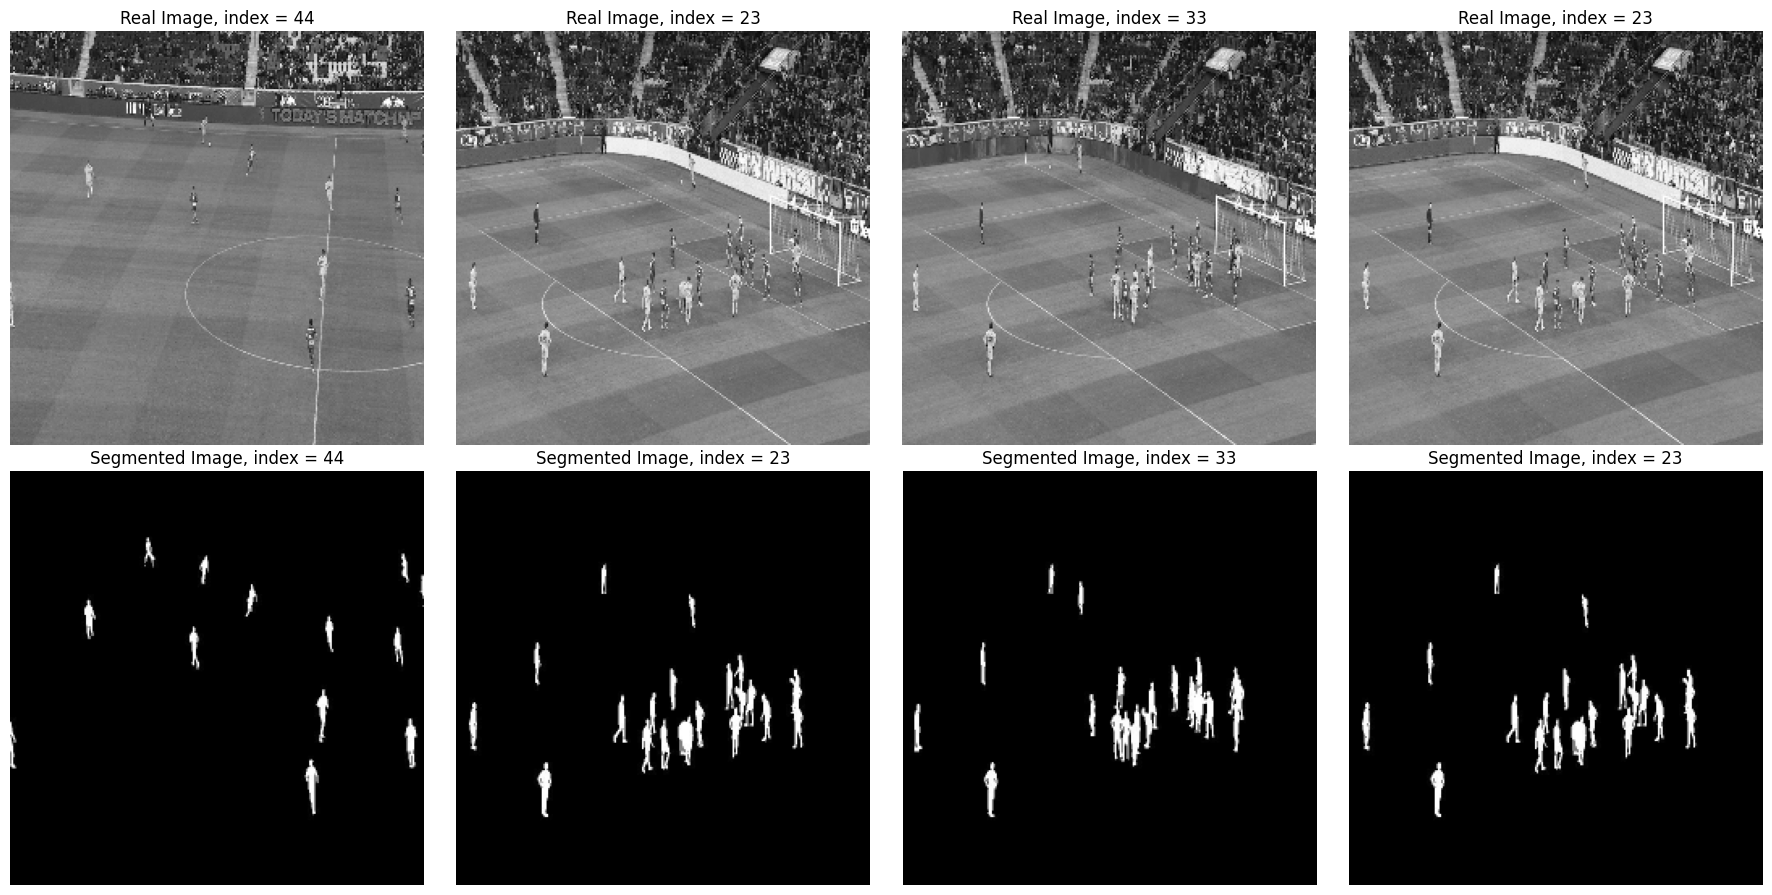

In [ ]:
# Plot validating images and masks
plot_image_with_mask(images_val, masks_val, 4)

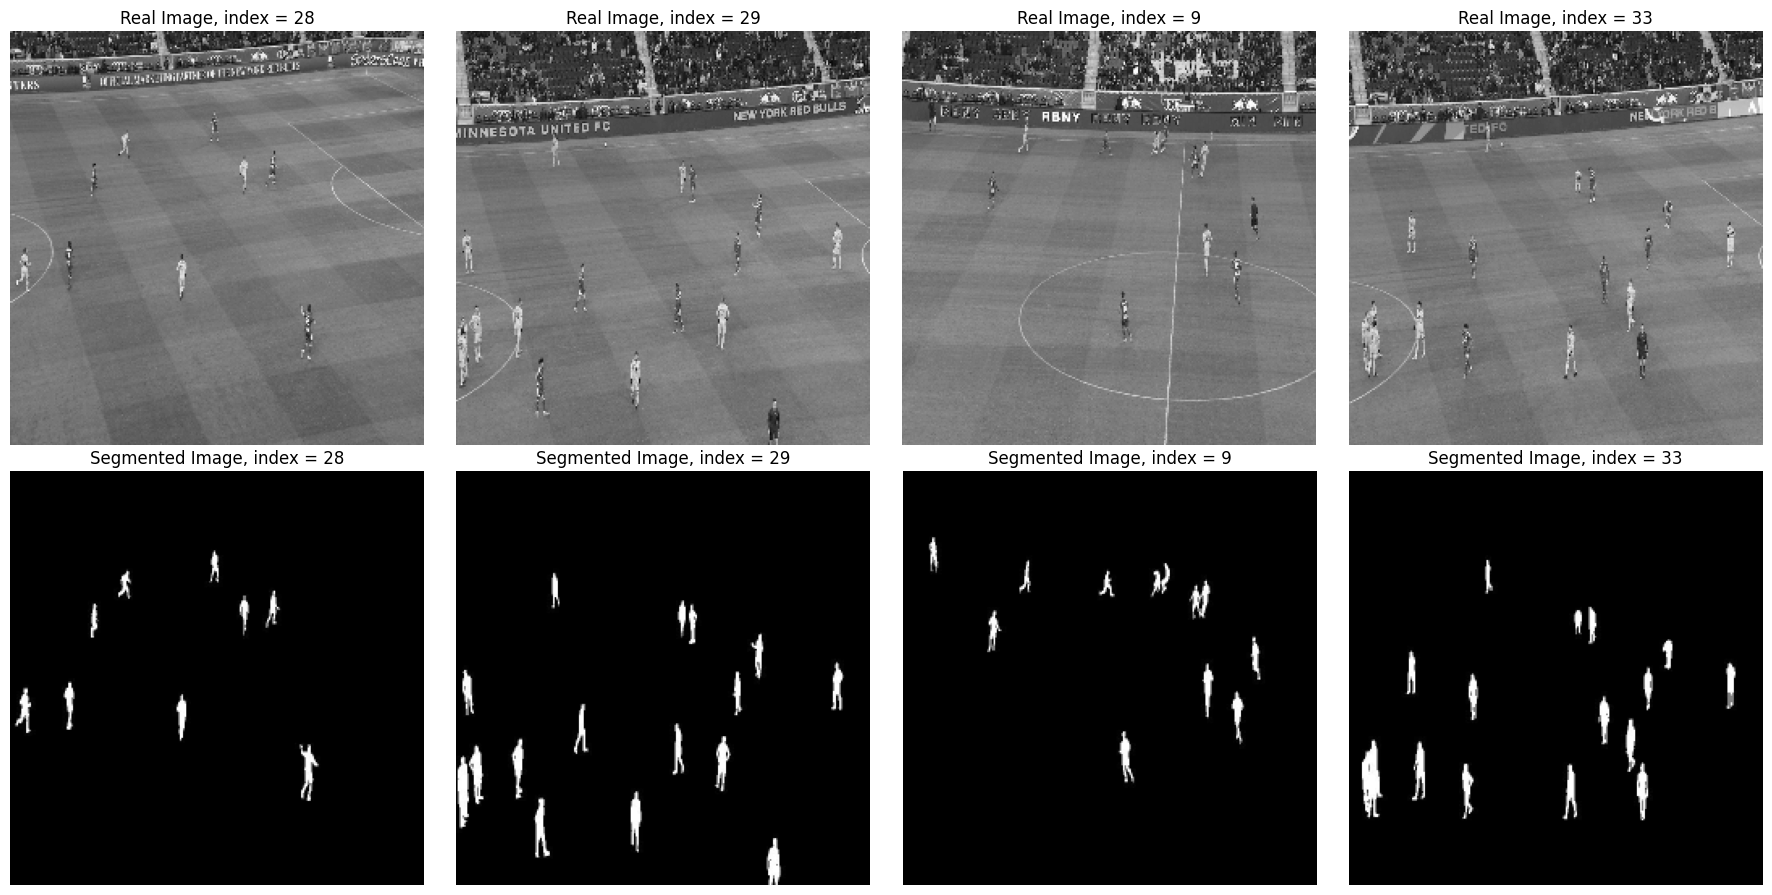

In [ ]:
# Plot testing images and masks
plot_image_with_mask(images_test, masks_test, 4)

## Convert images and masks into datasets and creating batches

In [ ]:
batch_size = 32

# Convert training images and masks into a dataset and batch them
train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

# Convert validation images and masks into a dataset and batch them
val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

# Convert test images and masks into a dataset and batch them
test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

## Implementing U-NET Convolutional Neural Network (CNN)
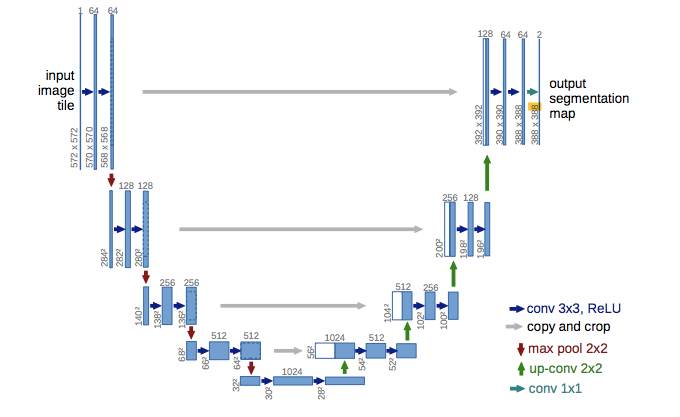

* The **encoder block** in a U-Net architecture downsamples the input image to extract relevant features for segmentation. It consists of two convolutional layers with ReLU activation functions (to introduce non-linearity) for feature extraction, followed by a max pooling layer for spatial dimension reduction. The block outputs two tensors: one containing the extracted features (`s`) for the decoder block, and the other providing downsampled feature maps (`p`) for the next encoder block. This process helps in summarizing key information from the input image for later use in the decoding process.

* The **baseline layer** acts as a bridge between the encoder and decoder in the network. It refines the features extracted by the encoder before passing them to the decoder for image reconstruction.

* The **decoder block** is used for reconstructing the segmented image by gradually upsampling the features from the encoder. It consists of upsampling operations using transposed convolutional layers to match the dimensions of skip connection feature maps. These skip connections, which concatenate the upsampled features with those from the encoder (`s`), allow the decoder to access both low-level and high-level information for preserving fine details. The concatenated features then pass through additional convolutional layers with ReLU activation functions to further refine the features and extract abstract representations, ultimately reconstructing the segmented image.

In [ ]:
# Encoder Block
def encoder_block(filters, inputs):
  x = Conv2D(filters, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu')(inputs)
  s = Conv2D(filters, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu')(x)
  p = MaxPooling2D(pool_size = (2,2), padding = 'same')(s)
  return s, p # p provides the input to the next encoder block and s provides the context/features to the symmetrically opposite decoder block

In [ ]:
# Baseline layer is just a bunch on Convolutional Layers to extract high level features from the downsampled Image
def baseline_layer(filters, inputs):
  x = Conv2D(filters, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu')(inputs)
  x = Conv2D(filters, kernel_size = (3,3), padding = 'same', strides = 1, activation = 'relu')(x)
  return x

In [ ]:
# Decoder Block
def decoder_block(filters, connections, inputs):
  x = Conv2DTranspose(filters, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(inputs)
  skip_connections = concatenate([x, connections], axis = -1)
  x = Conv2D(filters, kernel_size = (2,2), padding = 'same', activation = 'relu')(skip_connections)
  x = Conv2D(filters, kernel_size = (2,2), padding = 'same', activation = 'relu')(x)
  return x

In [ ]:
# Creating entire U-NET function
def unet():
  # Defining the input layer and specifying the shape of the images
  inputs = Input(shape = (256,256,1))

  # Defining the entire encoder
  s1, p1 = encoder_block(64, inputs = inputs)
  s2, p2 = encoder_block(128, inputs = p1)
  s3, p3 = encoder_block(256, inputs = p2)
  s4, p4 = encoder_block(512, inputs = p3)

  # Setting up the baseline
  baseline = baseline_layer(1024, p4)

  # Defining the entire decoder
  d1 = decoder_block(512, s4, baseline)
  d2 = decoder_block(256, s3, d1)
  d3 = decoder_block(128, s2, d2)
  d4 = decoder_block(64, s1, d3)

  # Setting up the output function for binary classification of pixels
  outputs = Conv2D(1, 1, activation = 'sigmoid')(d4)

  # Finalizing the model
  model = Model(inputs = inputs, outputs = outputs, name = 'Unet')

  return model

## Setting up evaluation metrics

The Dice Coefficient is better for tasks where balancing false positives and false negatives is crucial, like in medical image analysis, while the Jaccard Index is more suitable for tasks emphasizing spatial overlap, such as object detection. Accuracy, on the other hand, is a general metric for overall performance but can be misleading with imbalanced datasets.

####**1. Dice Coefficient:**
* **Purpose:** Metric commonly used for evaluating the performance of image segmentation models
* **Explanation:** It measures the overlap between the predicted segmentation * mask and the ground truth mask
* **Interpretation:** Ranges from 0 to 1, with 1 indicating perfect overlap between the predicted and ground truth masks. Higher values indicate better segmentation performance

####**2. Jaccard Index (Intersection over Union):**
* **Purpose:** Metric used for evaluating the similarity and diversity of sample sets
* **Explanation:** It measures the intersection over the union of two sets, calculating the ratio of the size of the intersection to the size of the union
* **Interpretation:** Ranges from 0 to 1, with 1 indicating that the sets are identical, and 0 indicating no overlap between the sets. A higher Jaccard Index signifies a greater similarity between the sets

####**3. Accuracy:**
Predefined string using Keras so does not need to be defined like the other two metrics.
* **Purpose:** Metric that measures the proportion of correct predictions out of the total predictions made
* **Explanation:** For binary classification, it calculates the ratio of correctly predicted pixels to the total number of pixels in the image
* **Interpretation:** Higher accuracy values indicate better performance, with 1.0 indicating all predictions are correct

In [ ]:
# Defining dice coefficient to evaluate our model
def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice_coeff = (2 * intersection + smooth) / (union + smooth) # Main formula for dice coefficient
    return dice_coeff

In [ ]:
# Defining jaccard index to evaluate our model
def jaccard_index(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    jaccard_index = (intersection + 1e-7) / (union + 1e-7) # Main formula for jaccard index
    return jaccard_index

## Creating the U-NET Model

####**1. Binary Crossentropy (Loss Function):**
* **Purpose:** Used for binary classification tasks, such as pixel-wise binary segmentation (foreground/background)
* **Explanation:** Calculates the difference between the predicted probability distribution and the actual distribution of the binary labels. The goal is to minimize this difference during training
* **Interpretation:** Lower values indicate better model performance, with 0 indicating a perfect match between predicted and actual distributions

####**2. Adam Optimizer:**
* **Purpose:** An optimization algorithm used to update network weights iteratively based on training data
* **Explanation:** Stands for Adaptive Moment Estimation. It combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp. Adam adapts the learning rate for each parameter, providing better convergence properties and faster training
* **Interpretation:** Well-suited for training deep neural networks and is widely used in various machine learning tasks. It helps the model converge faster and often achieves good performance with default hyperparameters

In [ ]:
# Strategy object allocates multiple gpus for training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Creating model inside the strategy scope
    unet = unet()
    # Model is compiled with the binary cross-entropy loss function, the Adam optimizer, and metrics including accuracy and the Dice coefficient/Jaccard index
    unet.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', dice_coeff, jaccard_index])

# Printing the model summary
unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                            

In [ ]:
# Defining early stopping to regularize the model and prevent overfitting and improve generalization of the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Training the Data

* `unet.fit` is used to train the model (unet) on the training data (train_data). It iterates over the dataset for a specified number of epochs and updates the model's weights to minimize the loss function
* `validation_data=val_data` specifies the validation dataset (val_data) on which the model's performance is evaluated after each epoch. The validation data is used to monitor the model's performance and determine when to stop training using early stopping
* The model will be trained for a maximum of 50 epochs, but it will stop early if the validation loss does not improve for 3 consecutive epochs


In [ ]:
# Training the data for 50 epochs
unet_history = unet.fit(train_data,
                         validation_data=val_data,
                         epochs=50,
                         callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 126s 7s/step - loss: 0.3750 - accuracy: 0.9498 - dice_coeff: 0.0901 - jaccard_index: 0.0123 - val_loss: 0.1206 - val_accuracy: 0.9546 - val_dice_coeff: 0.0714 - val_jaccard_index: 0.0098
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 0.1137 - accuracy: 0.9507 - dice_coeff: 0.1177 - jaccard_index: 0.0074 - val_loss: 0.1083 - val_accuracy: 0.9546 - val_dice_coeff: 0.0892 - val_jaccard_index: 0.0085
Epoch 3/50
10/10 [==============================] - 16s 2s/step - loss: 0.1092 - accuracy: 0.9507 - dice_coeff: 0.1140 - jaccard_index: 0.0075 - val_loss: 0.1034 - val_accuracy: 0.9546 - val_dice_coeff: 0.0983 - val_jaccard_index: 0.0084
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 0.1060 - accuracy: 0.9507 - dice_coeff: 0.1154 - jaccard_index: 0.0080 - val_loss: 0.0978 - val_accuracy: 0.9546 - val_dice_coeff: 0.1159 - val_jaccard_index: 0.0084
Epoch 5/50
10/10 [=============================

## Evaluating the model and results

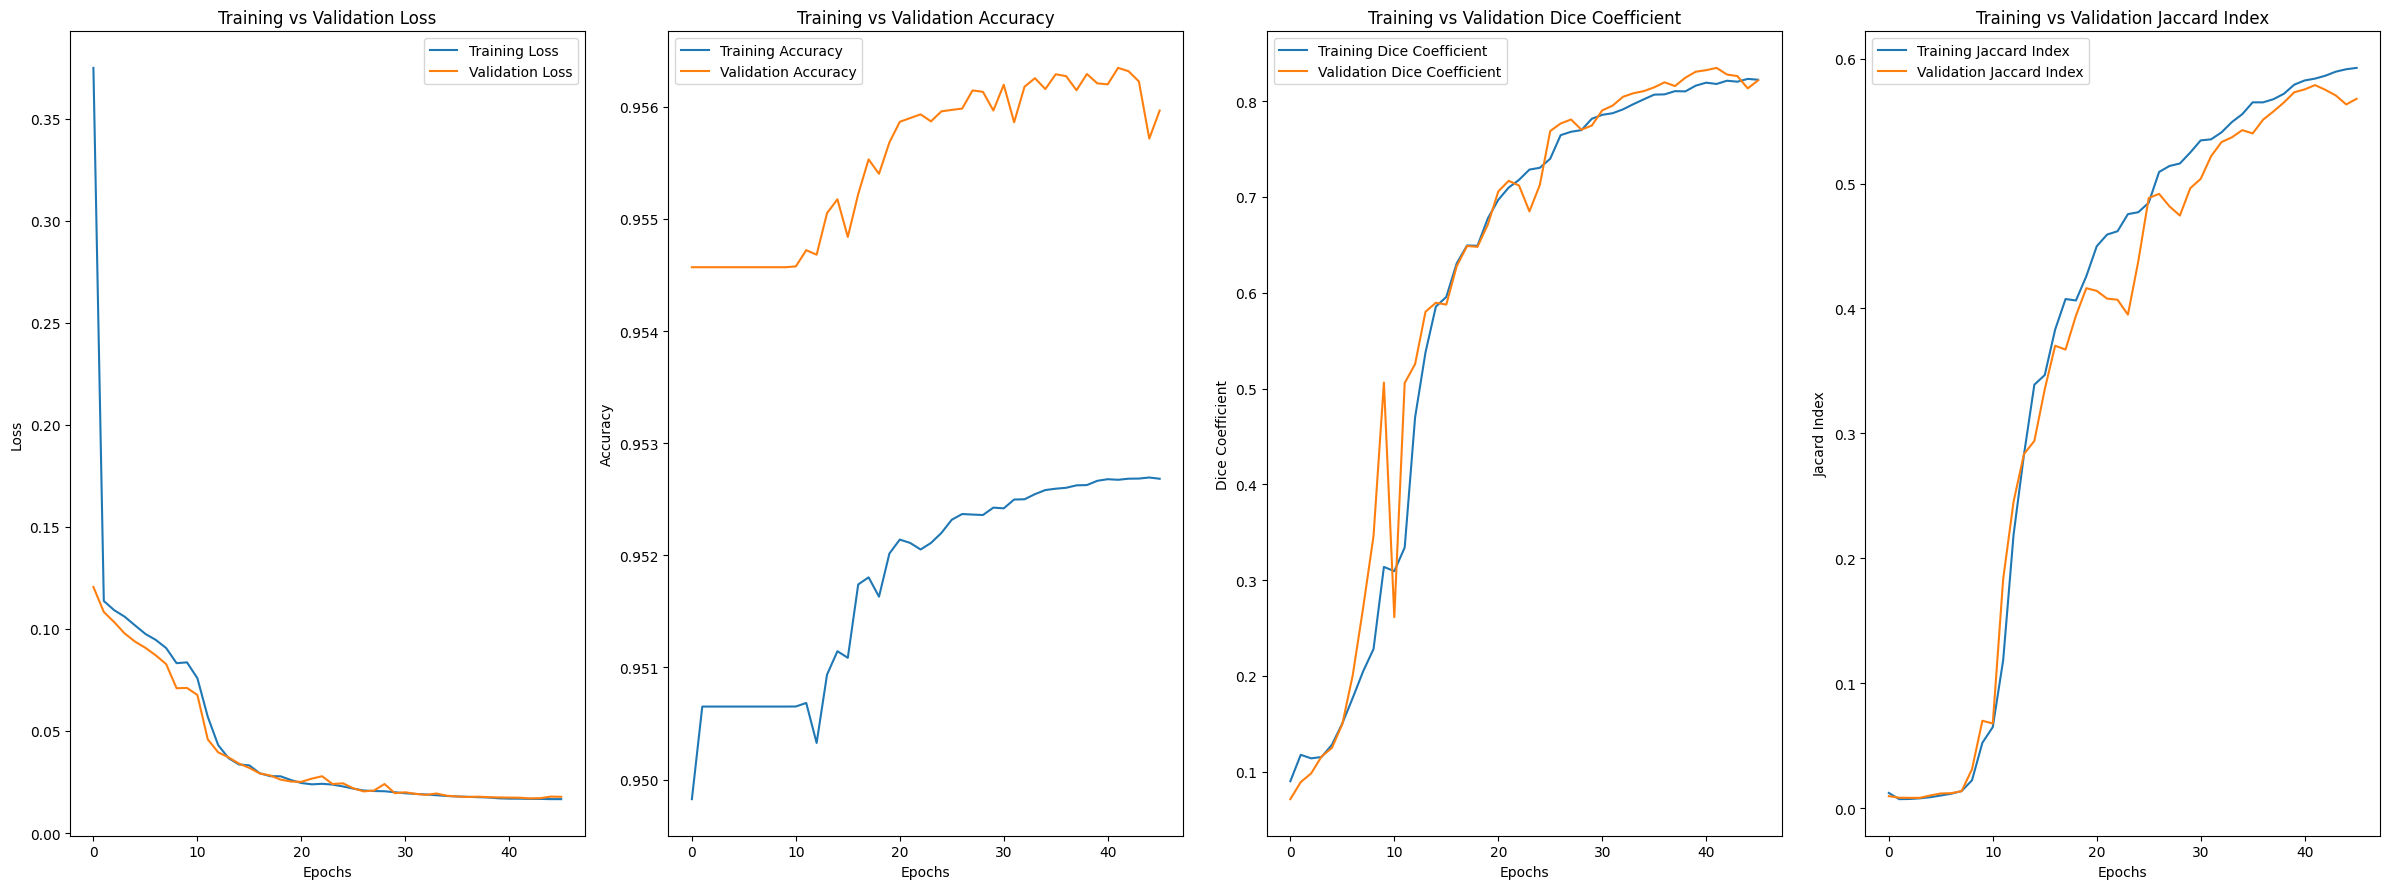

In [ ]:
# Creates a new figure for the plot
plt.figure(figsize=(24, 9))

# Plotting the loss
plt.subplot(1, 4, 1)
plt.plot(unet_history.history['loss'], label='Training Loss')
plt.plot(unet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 4, 2)
plt.plot(unet_history.history['accuracy'], label='Training Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plotting the Dice coefficient
plt.subplot(1, 4, 3)
plt.plot(unet_history.history['dice_coeff'], label='Training Dice Coefficient')
plt.plot(unet_history.history['val_dice_coeff'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice Coefficient')
plt.legend()

# Plotting the Jaccard Index
plt.subplot(1, 4, 4)
plt.plot(unet_history.history['jaccard_index'], label='Training Jaccard Index')
plt.plot(unet_history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.xlabel('Epochs')
plt.ylabel('Jacard Index')
plt.title('Training vs Validation Jaccard Index')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluating the model's accuracy
evaluation = unet.evaluate(test_data)
print(f"Model Accuracy: {evaluation[1]*100:.2f}%")

4/4 [==============================] - 8s 2s/step - loss: 0.0162 - accuracy: 0.9553 - dice_coeff: 0.8204 - jaccard_index: 0.5931
Model Accuracy: 95.53%


## Plotting the predictions with orginal image, original mask and predicted mask

In [ ]:
def plot_preds(idx):
    # Get the test image at the specified index
    test_img = images_test[idx]
    # Expand dimensions to match model input shape
    test_img = tf.expand_dims(test_img, axis=0)
    test_img = tf.expand_dims(test_img, axis=-1)

    # Get the model's prediction for the test image
    pred = unet.predict(test_img)
    pred = pred.squeeze()  # Remove all dimensions of size 1

    # Create a binary mask from predicted values (>0.5 = True and corresponding pixel in the original image is predicted to belong to the object)
    thresh = pred > 0.5

    # Creates a new figure for the plot
    plt.figure(figsize=(15, 15))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images_test[idx], cmap='hsv')
    plt.title(f'Original Image {idx}')
    plt.axis('off')

    # Actual Mask
    plt.subplot(1, 3, 2)
    plt.imshow(masks_test[idx], cmap='gray')
    plt.title('Actual Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(thresh, cmap='gray') # Plots binary mask as an image
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
# Generate 10 random indices
random_indices = [random.randint(0, len(images_test) - 1) for i in range(10)]

# Plot predictions for each random index
for i in random_indices:
    plot_preds(i)

## Save the model and create a zip file

In [ ]:
# Save the model
unet.save('football_game_unet_model')

# Zip the saved model files
import shutil
shutil.make_archive('football_game_unet_model', 'zip', 'football_game_unet_model')

# Provide a download link for the zip file
from IPython.display import FileLink
FileLink('football_game_unet_model.zip')

/content/football_game_unet_model.zip